# 🎓[Training] Student Perf from Gameplay
---
In this notebook, I used the baseline of *Chris Deotte* based on the idea proposed by *DataManyo*. You can check out there respective works:
- [XGBoost Baseline - [0.676]](https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-676/notebook)
- [🥇 LightGBM baseline with aggregated log data](https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data)

I am also using **RAPIDS cuDF** instead of pandas to take advantage of GPU acceleration for reading the data, feature engineering, and training. The modifications are showed in this notebook by *Shashwat Raman*.
- [GPU XGB Baseline (Using RAPIDS cuDF) - Train](https://www.kaggle.com/code/shashwatraman/gpu-xgb-baseline-using-rapids-cudf-train/notebook)


I will keep track of my progress during the start of the competition. My goal now is to improve this baseline.

## ✨Progress
- ***Baseline: LB Score:* 0.676**
 - Training using 18 XGBoost models for individual questions.
 - The data is grouped into 3 groups of questions and statistics of the features are calculated.
 - Cross validation on 5 folds and training on 80% of the data (last fold).
- ***Increasing number of CV folds:* LB Score: 0.677**
 - Using 20 folds for cross-validation and training on 95% of the data [(Chris Deotte suggestion)](https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-676/comments#2146075).
 - Tried with 10 folds - LB Score: 0.676
- ***Training on full data:* LB Score: 0.667** (with 5 folds)
 - Averaging the `best_ntree_limit` along the folds for each question.
 - Try with 5, 10, 20 folds for the average
 - The performance was slightly better by averaging 5 folds
- **LB Score:**
 - Added min/max features
 - Added room counts

# Parameters
Here are the parameters related to the model strategy.
- `xgb_params`: You can check the different parameters available for XGBoost. Check the documentation [here](https://xgboost.readthedocs.io/en/stable/).
- `SAVE`: Save the 'models' dictionnary as json files.
- `N_FOLDS`: Number of folds for the cross-validation.
- `RETRAIN_WITH_ALL_DATA`: Retrain or not a final model using all of the data, with the number of estimators for each model determined by the averages obtained during cross-validation. If set to False, the final model is trained using the exact numbers of estimators but on the last fold of cross-validation.
- `INFERENCE`: Choose to use this notebook for inference. Use CPU for it.
- `MODEL_PATH`: The path to the dictionary of models stored as a dataset.

In [1]:
PATH = '/kaggle/input/predict-student-performance-from-game-play'

# Model params
xgb_params = {'objective': 'binary:logistic',
              'eval_metric': 'logloss',
              'learning_rate': 0.05,
              'max_depth': 4,
              'n_estimators': 1000,
              'early_stopping_rounds': 50,
              'tree_method': 'gpu_hist',
              'subsample': 0.8,
              'colsample_bytree': 0.4,
              'use_label_encoder': False}

# Save the models as json files
SAVE = True

# Cross validation
N_FOLDS = 5

# Retrain using all data
RETAIN_WITH_ALL_DATA = True

# Use as inference notebook (Use with CPU)
INFERENCE = False
MODELS_DIR = '/kaggle/input/student-perf-from-gameplay-models'

# Imports

In [2]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GroupKFold
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

from tqdm.notebook import tqdm
import zipfile
from IPython.display import FileLink

if INFERENCE:
    import pandas as pd
    print('Pandas version:', pd.__version__)
else:
    import cudf
    print('RAPIDS cuDF version:', cudf.__version__)

RAPIDS cuDF version: 21.10.01


# Read the training data

In [3]:
if not INFERENCE:
    train = cudf.read_csv(f'{PATH}/train.csv')
    labels = cudf.read_csv(f'{PATH}/train_labels.csv')
    labels['session'] = cudf.to_numeric(labels.session_id.str.split('_').list.get(0))
    labels['question'] = cudf.to_numeric(labels.session_id.str.split('_q').list.get(1))
    print("Training set loaded.")
else:
    print("Inference. No training set needed.")

Training set loaded.


# Feature engineering
I will use the idea of aggreagating the data by `session_id` and `level_group`. Check out the references at the beginning of the notebook.

The aim is to create interesting features from these groups that we can use to train one model per question level.

In [4]:
def feature_engineer(train):
    
    # Prepare features
    GROUP_COLS = ['session_id', 'level_group']
    CATS = ['event_name', 'name', 'text', 'fqid', 'room_fqid', 'text_fqid']
    NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']
    EVENT_NAMES = ['navigate_click', 'person_click', 'cutscene_click',
               'object_click', 'map_hover', 'notification_click',
               'map_click', 'observation_click', 'checkpoint']
    ROOMS = ['tunic.capitol_0.hall', 'tunic.capitol_1.hall',
             'tunic.capitol_2.hall', 'tunic.drycleaner.frontdesk',
             'tunic.flaghouse.entry', 'tunic.historicalsociety.basement',
             'tunic.historicalsociety.cage', 'tunic.historicalsociety.closet',
             'tunic.historicalsociety.closet_dirty',
             'tunic.historicalsociety.collection',
             'tunic.historicalsociety.collection_flag',
             'tunic.historicalsociety.entry',
             'tunic.historicalsociety.frontdesk',
             'tunic.historicalsociety.stacks', 'tunic.humanecology.frontdesk',
             'tunic.kohlcenter.halloffame', 'tunic.library.frontdesk',
             'tunic.library.microfiche', 'tunic.wildlife.center']
    
    dfs = []
    
    # N unique
    for c in CATS:
        tmp = train.groupby(GROUP_COLS)[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)

    # Mean
    for c in NUMS:
        tmp = train.groupby(GROUP_COLS)[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)

    # Standard deviation
    for c in NUMS:
        tmp = train.groupby(GROUP_COLS)[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    
    # Maximum
    for c in NUMS:
        tmp = train.groupby(GROUP_COLS)[c].agg('max')
        tmp.name = tmp.name + '_max'
        dfs.append(tmp)
    
    # Minimum
    for c in NUMS:
        tmp = train.groupby(GROUP_COLS)[c].agg('min')
        tmp.name = tmp.name + '_min'
        dfs.append(tmp)
        
    # Count event names
    for c in EVENT_NAMES:
        train[c] = (train['event_name'] == c).astype('int8')
        tmp = train.groupby(GROUP_COLS)[c].agg('sum')
        tmp.name = tmp.name + '_count'
        dfs.append(tmp)
        train = train.drop(c, axis=1)
        
    # Count rooms
    for c in ROOMS:
        train[c] = (train['room_fqid'] == c).astype('int8')
        tmp = train.groupby(GROUP_COLS)[c].agg('sum')
        tmp.name = tmp.name + '_count'
        dfs.append(tmp)
        train = train.drop(c, axis=1)
        
    # Concatenate everything
    try: df = cudf.concat(dfs, axis=1)
    except: df = pd.concat(dfs, axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    
    return df

Now that we have defined the feature engineering function, we can apply it to the raw dataframe and examine the resulting aggregated dataframe, which we will use for training. Note that we have not normalized the features, because the XGBoost classifier we are using is a tree-based model. Typically, tree-based models do not require normalization, as their decision boundaries are based on the relative values of the features.

In [5]:
if not INFERENCE:
    %time df = feature_engineer(train).to_pandas()
    FEATURES = [c for c in df.columns if c != 'level_group']
    SESSIONS = df.index.unique()
    print("Nb of features used for training:", len(FEATURES))
    print("Nb of different sessions:", len(SESSIONS))
else:
    print("Inference. Feature engineering on the test set only.")

CPU times: user 6.14 s, sys: 1.9 s, total: 8.04 s
Wall time: 8.48 s
Nb of features used for training: 66
Nb of different sessions: 11779


# Cross validation
The purpose of cross-validation is to **evaluate the performance of our model** and to assess its generalization capability. The idea behind cross-validation is to split the data into several folds, and to use each fold as a validation set while the remaining data is used for training. This process is repeated several times, with each fold being used as the validation set once. It also helps to avoid overfitting, which occurs when a model is too complex and fits the training data too closely, leading to poor performance on new data.

In [6]:
if not INFERENCE:
    
    gkf = GroupKFold(n_splits=N_FOLDS)
    oof = cudf.DataFrame(data=np.zeros((len(SESSIONS), 18)), index=SESSIONS)
    models = {}
    best_ntree_limits = {} # to keep track of it in case of retraining

    # Compute CV score with 5-group K-fold
    for i, (train_index, valid_index) in enumerate(gkf.split(X=df, groups=df.index)):
        print('\033[1m\033[94m-' * 80, f"\n{' ' * 35}FOLD {i + 1}")
        print('-' * 80, '\033[0m')

        # Iterate from question 1 to 18
        for q in range(1, 19):

            # Select the question group
            if q <= 3: grp = '0-4'
            elif q <=13: grp = '5-12'
            elif q <= 22: grp = '13-22'

            # Train data
            train_x = df.iloc[train_index]
            train_x = train_x[train_x.level_group == grp]
            train_sessions = train_x.index.values
            train_y = labels[labels.question == q]\
                .set_index('session').loc[train_sessions]

            # Valid data
            valid_x = df.iloc[valid_index]
            valid_x = valid_x[valid_x.level_group == grp]
            valid_sessions = valid_x.index.values
            valid_y = labels[labels.question == q]\
                .set_index('session').loc[valid_sessions]

            # Train model
            clf = XGBClassifier(**xgb_params)
            clf.fit(train_x[FEATURES].astype('float32'),
                    train_y['correct'],
                    eval_set=[(valid_x[FEATURES].astype('float32'),
                               valid_y['correct'])],
                    verbose=0)

            # Best_ntree_limit
            best_ntree_limits[f'fold{i+1}_q{q}'] = clf.best_ntree_limit
            print(f'Q{q}({clf.best_ntree_limit}), ', end='')

            # Save and predict valid
            models[f'{grp}_{q}'] = clf
            oof.loc[valid_sessions, q - 1] = clf.predict_proba(valid_x[FEATURES])[:, 1]

        print()
        
    print("\nCross validation finished.")
    
else:
    print("Inference. No cross validation.")

-------------------------------------------------------------------------------- 
                                   FOLD 1
-------------------------------------------------------------------------------- 
Q1(168), Q2(189), Q3(112), Q4(308), Q5(96), Q6(176), Q7(144), Q8(101), Q9(115), Q10(127), Q11(140), Q12(79), Q13(115), Q14(192), Q15(125), Q16(85), Q17(67), Q18(146), 
-------------------------------------------------------------------------------- 
                                   FOLD 2
-------------------------------------------------------------------------------- 
Q1(216), Q2(121), Q3(137), Q4(69), Q5(97), Q6(108), Q7(141), Q8(96), Q9(101), Q10(163), Q11(61), Q12(73), Q13(135), Q14(82), Q15(93), Q16(63), Q17(45), Q18(85), 
-------------------------------------------------------------------------------- 
                                   FOLD 3
-------------------------------------------------------------------------------- 
Q1(206), Q2(157), Q3(107), Q4(120), Q5(87), Q6(69), 

The models predicted values on the different validation folds are stored in the **out-of-fold** (oof) dataframe. These predictions represent the confidence that a given `session_id` and `question` are correct, on a scale from 0 to 1. We must now decide when to consider a question as correct or not by finding the threshold that gives the best final score. While we could arbitrarily take 0.5, **this value is not necessarily the best one**, and it is smarter to try different values to find the optimal threshold.

  0%|          | 0/31 [00:00<?, ?it/s]

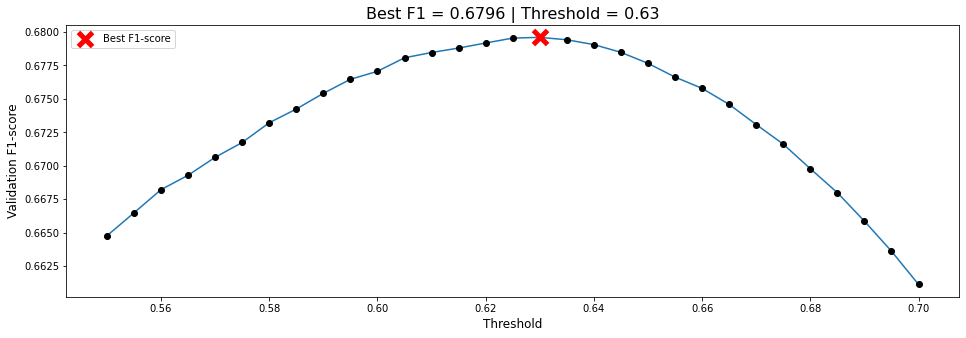

Using optimal threshold of 0.63
-----------------------------------
 Q1: F1 = 0.606820
 Q2: F1 = 0.494615
 Q3: F1 = 0.489804
 Q4: F1 = 0.626662
 Q5: F1 = 0.575302
 Q6: F1 = 0.608647
 Q7: F1 = 0.599481
 Q8: F1 = 0.529237
 Q9: F1 = 0.606214
 Q10: F1 = 0.501482
 Q11: F1 = 0.593911
 Q12: F1 = 0.502360
 Q13: F1 = 0.432425
 Q14: F1 = 0.612137
 Q15: F1 = 0.507235
 Q16: F1 = 0.457237
 Q17: F1 = 0.543378
 Q18: F1 = 0.490521
-----------------------------------
Overall F1 = 0.679604


In [7]:
if not INFERENCE:
    
    # Put true labels into dataframe with 18 columns
    true = oof.copy()
    for q in range(1, 19):
        tmp = labels.loc[labels.question == q].set_index('session')
        true[q - 1] = tmp['correct'].values

    # Find the optimal threshold for the final preditions
    scores, thresholds = [], []
    best_score, best_threshold = 0, 0
    for thr in tqdm(np.arange(0.550, 0.705, 0.005)):
        preds = (oof.to_pandas().values > thr).astype(int).reshape(-1)
        m = f1_score(true.to_pandas().values.reshape(-1), preds, average='macro')
        scores.append(m)
        thresholds.append(thr)
        if m > best_score:
            best_score = m
            best_threshold = round(thr, 3)
    models['threshold'] = best_threshold

    # Display threshold curve
    plt.figure(figsize=(16, 5))
    plt.scatter(best_threshold, best_score, s=200,
                marker='x', color='red', lw=5, zorder=2)
    plt.plot(thresholds, scores, zorder=0)
    plt.scatter(thresholds, scores, color='black')
    plt.legend(['Best F1-score'], loc='upper left')
    plt.xlabel("Threshold", size=12)
    plt.ylabel("Validation F1-score", size=12)
    plt.title(f"Best F1 = {best_score:.4f} | Threshold = {best_threshold}", size=16)
    plt.show()

    # Detail for each model
    print(f"Using optimal threshold of {best_threshold}")
    print('-' * 35)
    for k in range(18):
    
        # Compute F1 score per question
        preds = (oof[k].to_pandas().values > best_threshold).astype(int)
        m = f1_score(true[k].to_pandas().values, preds, average='macro')
        print(f" Q{k+1}: F1 = {m:.6f}")
    
    preds = (oof.to_pandas().values.reshape((-1)) > best_threshold).astype('int')
    m = f1_score(true.to_pandas().values.reshape((-1)), preds, average='macro')
    print('-' * 35)
    print(f"Overall F1 = {m:.6f}")

else:
    print("Inference.")

After trying different thresholds in the range of [0.40, 0.80], we observe that the validation F1-score follows a bell curve. The optimal threshold is the one that **maximizes this curve**, and we should use this value when reusing this model for inference.

# Retraining
The model can be retrained on **all the data**  after cross-validation. To do this, we take the average of the `best_ntree_limit` values across the folds for each of the 18 models, since the stopping criterion is based on a validation set. However, we do not have access to a validation set when retraining the model on all the data.

In [8]:
if INFERENCE:
    print("Inference mode. Use models from the dataset.")

elif RETAIN_WITH_ALL_DATA:
    print('\033[1m\033[94m-' * 80, f"\n{' ' * 35}RETRAINING")
    print('-' * 80, '\033[0m')
    
    # Average best trees
    estimators = []
    for q in range(1, 19):
        avg = 0
        for fold in range(1, N_FOLDS + 1):
            avg += best_ntree_limits[f'fold{fold}_q{q}'] / N_FOLDS
        estimators.append(round(avg))
        
    # Disable early stopping
    xgb_params['early_stopping_rounds'] = None

    models = {}
    # Iterate from question 1 to 18
    for q in range(1, 19):   
        # Select the number of estimators
        xgb_params['n_estimators'] = estimators[q - 1]
        
        # Select the question group
        if q <= 3: grp = '0-4'
        elif q <=13: grp = '5-12'
        elif q <= 22: grp = '13-22'

        # Train data
        train_x = df[df.level_group == grp]
        train_y = labels[labels.question == q].set_index('session')

        # Train model
        clf = XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'),
                train_y['correct'],
                verbose=0)

        print(f'Q{q}({clf.best_ntree_limit}), ', end='')

        # Save model
        models[f'{grp}_{q}'] = clf

    print("\n\nThe models have been retrained using all the data.")

else:
    print("No retraining. Models trained with last fold.")

-------------------------------------------------------------------------------- 
                                   RETRAINING
-------------------------------------------------------------------------------- 
Q1(176), Q2(139), Q3(119), Q4(153), Q5(89), Q6(118), Q7(110), Q8(67), Q9(103), Q10(97), Q11(92), Q12(109), Q13(104), Q14(141), Q15(133), Q16(69), Q17(66), Q18(111), 

The models have been retrained using all the data.


# Save models
I save the dictionary of models in **json format** in order to reuse it in another inference notebook.

In [9]:
if INFERENCE:
    print("Inference mode.")
elif SAVE:
    os.makedirs('models', exist_ok=True)
    # Save threshold
    thr_dict = {'threshold': best_threshold}
    with open("models/threshold.json", "w") as f:
        json.dump(thr_dict, f)
    # Save models
    for name, model in models.items():
        model.save_model(f'models/{name}.json')
    # Zip the folder
    folder_name = 'models'
    with zipfile.ZipFile('models.zip', mode="w") as my_zip:
        for root, _, files in os.walk(folder_name):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_name)
                my_zip.write(file_path, arcname=arcname)
else:
    print("Models not saved.")

# Inference
Inference **should use the CPU**

In [10]:
if INFERENCE:
    
    # Use the competition env
    import jo_wilder
    env = jo_wilder.make_env()
    iter_test = env.iter_test()

    # Predict and create submission file
    limits = {'0-4': (1, 4), '5-12': (4, 14), '13-22': (14, 19)}
    with open(f'{MODELS_DIR}/threshold.json', 'r') as f:
        threshold = json.load(f)['threshold']
    for (sample_submission, test) in iter_test:
        df = feature_engineer(test)
        FEATURES = [c for c in df.columns if c != 'level_group']
        grp = test.level_group.values[0]
        a, b = limits[grp]
        for q in range(a, b):
            clf = XGBClassifier()
            clf.load_model(f'{MODELS_DIR}/{grp}_{q}.json')
            p = clf.predict_proba(df[FEATURES])[:, 1]
            mask = sample_submission.session_id.str.contains(f'q{q}')
            sample_submission.loc[mask, 'correct'] = int(p.item() > threshold)
        env.predict(sample_submission)

    # Check submission
    df = pd.read_csv('submission.csv')
    print(df.shape)

else:
    print("No inference.")

No inference.


**Thank you for reading me, good luck in the competition! 🙂**